# Portfolio Selection Optimization
This model is an example of the classic [Markowitz portfolio selection optimization model](https://en.wikipedia.org/wiki/Markowitz_model). We want to find the fraction of the portfolio to invest among a set of stocks that balances risk and return. It is a Quadratic Programming (QP) model with vector and matrix data for returns and risk, respectively. This is best suited to a matrix formulation, so we use the Gurobi Python *matrix* interface. The basic model is fairly simple, so we also solve it parametrically to find the efficient frontier.

**Download the Repository** <br /> 
You can download the repository containing this and other examples by clicking [here](https://github.com/Gurobi/modeling-examples/archive/master.zip). 


## Model Formulation
### Parameters

We use the [Greek values](https://en.wikipedia.org/wiki/Greeks_\(finance\)) that are traditional in finance:

- $\delta$: n-element vector measuring the change in price for each stock
- $\sigma$: n x n matrix measuring the covariance among stocks

There is one additional parameter when solving the model parametrically:

- r: target return


### Decision Variables
- $x \ge 0$: n-element vector where each element represents the fraction of the porfolio to invest in each stock

### Objective Function
Minimize the total risk, a convex quadratic function:

\begin{equation}
\min x^t \cdot \sigma \cdot x
\end{equation}

### Constraints

Allocate the entire portfolio: the total investments should be 1.0 (100%), where $e$ is a unit vector (all 1's):

\begin{equation}
e \cdot x = 1
\end{equation}


Return: When we solve the model parametrically for different return values $r$, we add a constraint on the target return:

\begin{equation}
\delta \cdot x = r
\end{equation}

## Python Implementation
### Stock data
Use [yfinance](https://pypi.org/project/yfinance/) library to get the latest 2 years of _actual stock data_ from the 20 most profitable US companies, [according to Wikipedia in April 2021](https://en.wikipedia.org/wiki/List_of_largest_companies_in_the_United_States_by_revenue#List_of_companies_by_profit).
We use dummy data. Uncomment and comment the respected lines if you want to try data import with yfinance.

In [8]:
#%pip install gurobipy yfinance

In [9]:
#import yfinance as yf
import pandas as pd

stocks = ['BRK-A', 'AAPL', 'MSFT', 'JPM', 'GOOG', 'BAC', 'INTC', 'WFC',
          'C', 'VZ', 'META', 'PFE', 'JNJ', 'WMT', 'XOM',
          'FNMA', 'T', 'UNH', 'CMCSA', 'V' ]

#data = yf.download(stocks, period='2y')

# dummy data for the case import with yfinance is not working
csv_path = "dummy_yfinance_2y.csv"  # <- your CSV path
data = pd.read_csv(csv_path, header=[0,1], index_col=0, parse_dates=True)


### Compute Greeks
Using the downloaded stock data, find the delta (return), sigma (covariance) and standard deviation values for stock prices:

In [10]:
import numpy as np

closes = np.transpose(np.array(data.Close)) # matrix of daily closing prices
absdiff = np.diff(closes)                   # change in closing price each day
reldiff = np.divide(absdiff, closes[:,:-1]) # relative change in daily closing price
delta = np.mean(reldiff, axis=1)            # mean price change
sigma = np.cov(reldiff)                     # covariance (standard deviations)
std = np.std(reldiff, axis=1)               # standard deviation

## Minimize risk by solving QP model

In [11]:
import gurobipy as gp
from gurobipy import GRB
from math import sqrt

# Create an empty model
m = gp.Model('portfolio')

# Add matrix variable for the stocks
x = m.addMVar(len(stocks))

# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ sigma @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)

# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')

# Verify model formulation
m.write('portfolio_selection_optimization.lp')

# Optimize model to find the minimum risk portfolio
m.optimize()

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: Intel(R) Core(TM) Ultra 7 268V, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

WLS license 2531600 - registered to Gurobi Optimization
Optimize a model with 1 rows, 20 columns and 20 nonzeros (Min)
Model fingerprint: 0x08e5b1fe
Model has 0 linear objective coefficients
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-07, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 20 columns, 20 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 1.900e+02
 Factor NZ  : 2.100e+02
 Factor Ops : 2.870e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                

## Display minimum risk portfolio using Pandas

In [12]:
import pandas as pd
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
             index=stocks + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

,Minimum Risk Portfolio
BRK-A,0.054770
AAPL,0.036127
MSFT,0.037072
JPM,0.050740
GOOG,0.073484
BAC,0.069332
INTC,0.040853
WFC,0.053399
C,0.019793
VZ,0.041699


## Compute the efficient frontier
Solve the QP parametrically to find the lowest risk portfolio for different expected returns.

In [13]:
# Create an expression representing the expected return for the portfolio
portfolio_return = delta @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')

# Solve for efficient frontier by varying target return
frontier = np.empty((2,0))
for r in np.linspace(delta.min(), delta.max(), 25):
    target.rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 24.04.3 LTS")

CPU model: Intel(R) Core(TM) Ultra 7 268V, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

WLS license 2531600 - registered to Gurobi Optimization
Optimize a model with 2 rows, 20 columns and 40 nonzeros (Min)
Model fingerprint: 0x8b0ea04c
Model has 0 linear objective coefficients
Model has 210 quadratic objective terms
Coefficient statistics:
  Matrix range     [4e-06, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [1e-07, 1e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-04, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 20 columns, 40 nonzeros
Presolved model has 210 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 19
 AA' NZ     : 2.100e+02
 Factor NZ  : 2.310e+02
 Factor Ops : 3.311e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                

## Plot results
Use the matplot library to plot the optimized solutions, along with the individual stocks:

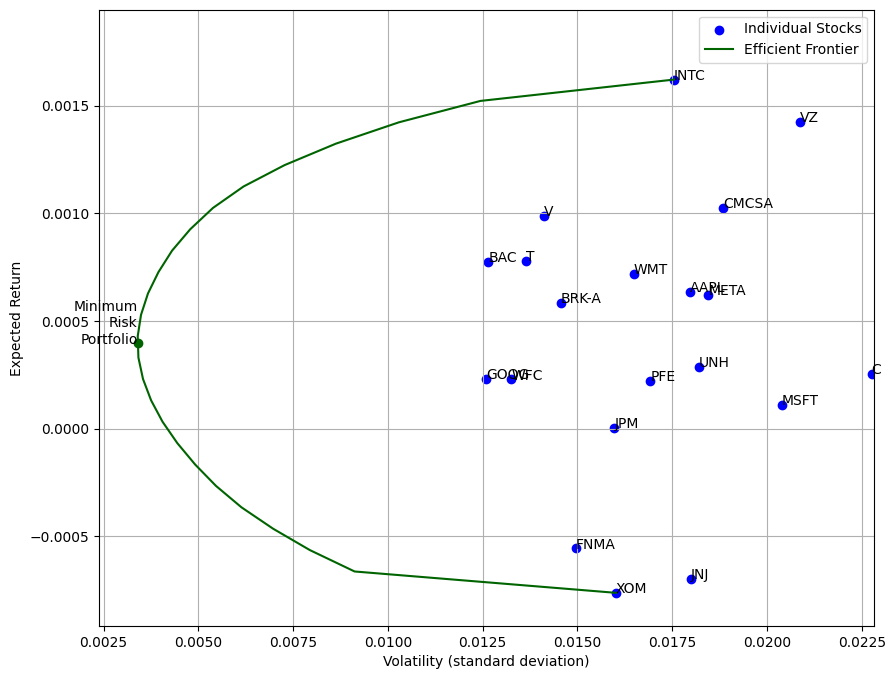

In [14]:
import matplotlib.pyplot as plt
#plt.figure(figsize=(10,10))

fig, ax = plt.subplots(figsize=(10,8))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=std, y=delta,
           color='Blue', label='Individual Stocks')
for i, stock in enumerate(stocks):
    ax.annotate(stock, (std[i], delta[i]))

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return),
            horizontalalignment='right')

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='DarkGreen')

# Format and display the final plot
ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, delta.min()*1.2, delta.max()*1.2])
ax.set_xlabel('Volatility (standard deviation)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
plt.show()